In [22]:
# Import Libraries
import os
import json
import datetime

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import gdal, ogr
import geopandas as gpd

from shapely.geometry import Polygon, Point
from shapely import wkt
import shapely

import folium
from rasterstats import zonal_stats


In [2]:
# Import folders
data_folder = os.path.abspath("data")
gisdata_folder = os.path.abspath("../gis_data")
output_folder = os.path.abspath("output")

#check if outfolder exists if not create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
# Import Sentinal Data
sentinal_store = os.path.abspath('../Sentinal Data Dump/Sentinal - 2/') #Change this when not on windows
village_shapefile = os.path.join(gisdata_folder, 'ap_village_boundary.shp')

In [4]:
# Trying OGr # But will use geopands for simplicity
'''a = vect_ds.GetLayer()
f = a.GetNextFeature()
f.GetGeometryRef().GetGeometryRef(0).GetPoint(0)'''

'a = vect_ds.GetLayer()\nf = a.GetNextFeature()\nf.GetGeometryRef().GetGeometryRef(0).GetPoint(0)'

In [46]:
# Import villages shapefile
vil_df_orig = gpd.read_file(village_shapefile).to_crs({'init': 'epsg:4326'})
vil_df_orig

,objectid,d_name,d_code,m_name,m_code,v_name,v_code,dmv_code,dhab_code,nhab_code,area,shape_leng,shape_area,geometry
0,1,PRAKASAM,08,JANAKAVARAMPANGULURU,26,RAMAKURU,001,0826001,08114260010101,08224260010101,9.868373,0.141020,0.000834,"POLYGON ((80.04985805210748 15.91367109064839,..."
1,2,KURNOOL,13,JUPADU BUNGALOW,15,BOLLAVARAM,004,1315004,13185150040104,13255150040104,10.979152,0.150349,0.000928,"POLYGON ((78.4009781286378 15.88795497584152, ..."
2,3,KURNOOL,13,ATMAKUR,11,PINNAPURAM,001,1331001,13184110010101,13254110010101,10.834390,0.184204,0.000916,"POLYGON ((78.65695250165669 15.90273718447355,..."
3,16,PRAKASAM,08,DONAKONDA,05,POLE PALLE,003,0805003,08121050030102,08222050030102,19.088614,0.177072,0.001614,"POLYGON ((79.46397430586956 15.88094116949941,..."
4,2599,POTTI SRIRAMULU NELLORE,None,MARRIPADU,None,FOREST,None,None,None,None,175.659844,1.194673,0.014757,"POLYGON ((79.18836768402144 14.7950505120715, ..."
5,9494,EAST GODAVARI,None,ATREYAPURAM,None,RIVER,None,None,None,None,55.954320,0.493842,0.004753,"POLYGON ((81.78699427376677 16.93263434260086,..."
6,4,PRAKASAM,08,MARTUR,20,LAKKAVARAM AGRAHARAM,009,0820009,08113200090110,08223200090110,2.254980,0.069647,0.000191,"POLYGON ((80.05762607668214 15.91305281303693,..."
7,5,KURNOOL,13,MANTRALAYAM,03,BUDUR,014,1303014,13177030140112,13264030140112,12.212523,0.128333,0.001032,"POLYGON ((77.40116162021263 15.86773176810664,..."
8,6,PRAKASAM,08,DONAKONDA,05,PADAMARA LAKSHMIPURAM,004,0805004,08121050040103,08222050040103,3.012021,0.085802,0.000255,"POLYGON ((79.39486102531612 15.88620473146324,..."
9,7,PRAKASAM,08,KARAMCHEDU,22,KARAMCHEDU,002,0822002,08111220020102,08223220020102,38.170193,0.239635,0.003227,"POLYGON ((80.31373576349472 15.91159896991655,..."


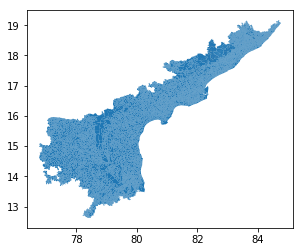

In [47]:
vil_df_orig.plot()

In [7]:
# Import data and footprint of all Sentinal 2 Imagery Available till now
sent_scenes = os.listdir(sentinal_store)
sent_scenes = [x for x in sent_scenes if x.split('.')[-1].lower() == 'zip']
print(f"-- Found {len(sent_scenes)} Scenes")
data_list = []
metadata_list = []
for x in sent_scenes:
    file = os.path.join(sentinal_store, sent_scenes[0])
    info = gdal.Info(file, format='json')
    data_list.append(info)
    metadata = info['metadata']['']
    metadata['SUBDATASETS'] = info['metadata']['SUBDATASETS']
    metadata_list.append(metadata)
    
# Convert to Geodataframe
df = pd.DataFrame(metadata_list)
df['FOOTPRINT'] = df['FOOTPRINT'].apply(lambda x : wkt.loads(x))
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry='FOOTPRINT')

# Add Additional Indformation
gdf['proj_epsg'] = gdf['SUBDATASETS'].apply(lambda x : x['SUBDATASET_1_NAME'].split('_')[-1])


gdf

-- Found 177 Scenes


,CLOUD_COVERAGE_ASSESSMENT,DATATAKE_1_DATATAKE_SENSING_START,DATATAKE_1_DATATAKE_TYPE,DATATAKE_1_ID,DATATAKE_1_SENSING_ORBIT_DIRECTION,DATATAKE_1_SENSING_ORBIT_NUMBER,DATATAKE_1_SPACECRAFT_NAME,DEGRADED_ANC_DATA_PERCENTAGE,DEGRADED_MSI_DATA_PERCENTAGE,FOOTPRINT,FORMAT_CORRECTNESS_FLAG,GENERAL_QUALITY_FLAG,GENERATION_TIME,GEOMETRIC_QUALITY_FLAG,PREVIEW_GEO_INFO,PREVIEW_IMAGE_URL,PROCESSING_BASELINE,PROCESSING_LEVEL,PRODUCT_START_TIME,PRODUCT_STOP_TIME,PRODUCT_TYPE,PRODUCT_URI,QUANTIFICATION_VALUE,RADIOMETRIC_QUALITY_FLAG,REFERENCE_BAND,REFLECTANCE_CONVERSION_U,SENSOR_QUALITY_FLAG,SPECIAL_VALUE_NODATA,SPECIAL_VALUE_SATURATED,SUBDATASETS,proj_epsg
0,3.2968,2015-11-28T05:01:42.031Z,INS-NOBS,GS2A_20151128T050142_002261_N02.04,DESCENDING,119,Sentinel-2A,0,0,"POLYGON ((80.06336269579832 16.34499181760359,...",PASSED,FAILED,2015-11-28T05:04:31.000000Z,PASSED,Not applicable,Not applicable,02.04,Level-1C,2015-11-28T05:01:42.031Z,2015-11-28T05:01:42.031Z,S2MSI1C,S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_2...,10000,PASSED,B1,1.02628690011494,PASSED,0,65535,{'SUBDATASET_1_NAME': 'SENTINEL2_L1C:/vsizip/D...,32644
1,3.2968,2015-11-28T05:01:42.031Z,INS-NOBS,GS2A_20151128T050142_002261_N02.04,DESCENDING,119,Sentinel-2A,0,0,"POLYGON ((80.06336269579832 16.34499181760359,...",PASSED,FAILED,2015-11-28T05:04:31.000000Z,PASSED,Not applicable,Not applicable,02.04,Level-1C,2015-11-28T05:01:42.031Z,2015-11-28T05:01:42.031Z,S2MSI1C,S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_2...,10000,PASSED,B1,1.02628690011494,PASSED,0,65535,{'SUBDATASET_1_NAME': 'SENTINEL2_L1C:/vsizip/D...,32644
2,3.2968,2015-11-28T05:01:42.031Z,INS-NOBS,GS2A_20151128T050142_002261_N02.04,DESCENDING,119,Sentinel-2A,0,0,"POLYGON ((80.06336269579832 16.34499181760359,...",PASSED,FAILED,2015-11-28T05:04:31.000000Z,PASSED,Not applicable,Not applicable,02.04,Level-1C,2015-11-28T05:01:42.031Z,2015-11-28T05:01:42.031Z,S2MSI1C,S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_2...,10000,PASSED,B1,1.02628690011494,PASSED,0,65535,{'SUBDATASET_1_NAME': 'SENTINEL2_L1C:/vsizip/D...,32644
3,3.2968,2015-11-28T05:01:42.031Z,INS-NOBS,GS2A_20151128T050142_002261_N02.04,DESCENDING,119,Sentinel-2A,0,0,"POLYGON ((80.06336269579832 16.34499181760359,...",PASSED,FAILED,2015-11-28T05:04:31.000000Z,PASSED,Not applicable,Not applicable,02.04,Level-1C,2015-11-28T05:01:42.031Z,2015-11-28T05:01:42.031Z,S2MSI1C,S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_2...,10000,PASSED,B1,1.02628690011494,PASSED,0,65535,{'SUBDATASET_1_NAME': 'SENTINEL2_L1C:/vsizip/D...,32644
4,3.2968,2015-11-28T05:01:42.031Z,INS-NOBS,GS2A_20151128T050142_002261_N02.04,DESCENDING,119,Sentinel-2A,0,0,"POLYGON ((80.06336269579832 16.34499181760359,...",PASSED,FAILED,2015-11-28T05:04:31.000000Z,PASSED,Not applicable,Not applicable,02.04,Level-1C,2015-11-28T05:01:42.031Z,2015-11-28T05:01:42.031Z,S2MSI1C,S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_2...,10000,PASSED,B1,1.02628690011494,PASSED,0,65535,{'SUBDATASET_1_NAME': 'SENTINEL2_L1C:/vsizip/D...,32644
5,3.2968,2015-11-28T05:01:42.031Z,INS-NOBS,GS2A_20151128T050142_002261_N02.04,DESCENDING,119,Sentinel-2A,0,0,"POLYGON ((80.06336269579832 16.34499181760359,...",PASSED,FAILED,2015-11-28T05:04:31.000000Z,PASSED,Not applicable,Not applicable,02.04,Level-1C,2015-11-28T05:01:42.031Z,2015-11-28T05:01:42.031Z,S2MSI1C,S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_2...,10000,PASSED,B1,1.02628690011494,PASSED,0,65535,{'SUBDATASET_1_NAME': 'SENTINEL2_L1C:/vsizip/D...,32644
6,3.2968,2015-11-28T05:01:42.031Z,INS-NOBS,GS2A_20151128T050142_002261_N02.04,DESCENDING,119,Sentinel-2A,0,0,"POLYGON ((80.06336269579832 16.34499181760359,...",PASSED,FAILED,2015-11-28T05:04:31.000000Z,PASSED,Not applicable,Not applicable,02.04,Level-1C,2015-11-28T05:01:42.031Z,2015-11-28T05:01:42.031Z,S2MSI1C,S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_2...,10000,PASSED,B1,1.02628690011494,PASSED,0,65535,{'SUBDATASET_1_NAME': 'SENTINEL2_L1C:/vsizip/D...,32644
7,3.2968,2015-11-28T05:01:42.031Z,INS-NOBS,GS2A_20151128T050142_002261_N02.04,

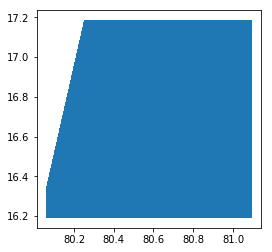

In [8]:
gdf.plot()

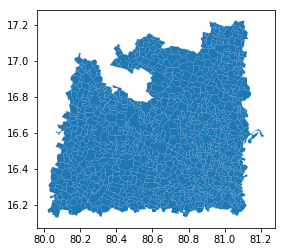

In [48]:
# Select list of villages for which we have satellite images
gdf = gdf.to_crs(vil_df.crs)
data_av = gdf.unary_union
vil_df = vil_df_orig[vil_df_orig.intersects(data_av)]
vil_df = vil_df.reset_index().drop(columns = ['index'])
vil_df.plot()

In [50]:
# Plot on map

## Init Map
c = data_av.centroid.wkt[7:-1].split()
centroid = [float(c[1]), float(c[0])]

m = folium.Map(
    location = centroid,
    zoom_start = 13
)

# Add Data Availability Layer
data_av_geo = json.dumps(shapely.geometry.mapping(data_av))
def data_av_style(x):
    return {
        "color" : 'red',
        "weight" : 2,
        #"fill_color" : 'blue',
        #"fill_opacity" : 0.5,
        "fill" : False,        
    }
data_av_layer = folium.GeoJson(
    data_av_geo,
    name='data_av',
    style_function = data_av_style
).add_to(m)

# Add Village Layer
vil_geo = vil_df['geometry'].simplify(tolerance = .005).to_json()
def vil_style(x):
    return {
        "color" : 'black',
        "weight" : 1,
        "fillColor" : 'red',
        "fillOpacity" : 0.2,
        "fill" : True,        
    }
    
vil_layer = folium.GeoJson(
    vil_geo,
    name='village',
    style_function = vil_style
).add_to(m)


m.fit_bounds(data_av_layer.get_bounds(), max_zoom=18)

m

CLOUD_COVERAGE_ASSESSMENT                                                        3.2968
DATATAKE_1_DATATAKE_SENSING_START                              2015-11-28T05:01:42.031Z
DATATAKE_1_DATATAKE_TYPE                                                       INS-NOBS
DATATAKE_1_ID                                        GS2A_20151128T050142_002261_N02.04
DATATAKE_1_SENSING_ORBIT_DIRECTION                                           DESCENDING
DATATAKE_1_SENSING_ORBIT_NUMBER                                                     119
DATATAKE_1_SPACECRAFT_NAME                                                  Sentinel-2A
DEGRADED_ANC_DATA_PERCENTAGE                                                          0
DEGRADED_MSI_DATA_PERCENTAGE                                                          0
FOOTPRINT                             POLYGON ((80.06336269579832 16.34499181760359,...
FORMAT_CORRECTNESS_FLAG                                                          PASSED
GENERAL_QUALITY_FLAG            

0    None
1    None
2    None
3    None
4    None
dtype: object

In [52]:
data_store = []

def calculate_mi(row, vil_df):
    # Open dataset
    #l1c_name = gdf['SUBDATASETS'][0]['SUBDATASET_2_NAME']
    #proj_epsg = gdf['proj_epsg'][0]

    l1c_name = row['SUBDATASETS']['SUBDATASET_2_NAME']
    print(f"\n-- Processing {l1c_name}")
    proj_epsg = row['proj_epsg']


    # Get Bounds For Filtered Villages
    vil_df_flt = vil_df[vil_df.intersects(row['FOOTPRINT'])]
    vil_df_flt = vil_df_flt.to_crs({'init': 'epsg:'+proj_epsg })
    print(f"-- Found {len(vil_df_flt)} Villages for getting statistics")
    bd = vil_df_flt.total_bounds
    aoi_bounds_for_gdal = [ bd[0], bd[3], bd[2], bd[1]]

    # Read Data
    raster_dataset = gdal.Open(l1c_name)
    #raster_dataset = gdal.Translate('', raster_dataset, format = 'MEM', projWin = aoi_bounds_for_gdal)#, outputType = gdal.GDT_UInt16)
    geo_transform = raster_dataset.GetGeoTransform()
    proj = raster_dataset.GetProjectionRef()
    n_bands = raster_dataset.RasterCount    
    metadata = raster_dataset.GetMetadata()

    # Extract Bands
    B8A = raster_dataset.GetRasterBand(4)
    #B8A.GetMetadata_Dict()
    B8A = B8A.ReadAsArray()

    B11 = raster_dataset.GetRasterBand(5)
    #B11.GetMetadata_Dict()
    B11 = B11.ReadAsArray()

    # Calculate Moisture Index
    mi = (B8A - B11)/(B8A + B11)

    # Calculate Statistics
    stats = zonal_stats(
        vil_df_flt,    
        mi, 
        transform=geo_transform,
        all_touched = True,
        stats=['min', 'max', 'mean', 'median', 'std', 'count', 'percentile_90']
        #stats=['min', 'max', 'mean', 'median', 'majority', 'std', 'count', 'percentile_90']
    )

    mi_df = pd.DataFrame(stats)

    mi_df = vil_df_flt[['d_name', 'd_code', 'm_name', 'm_code', 'v_name', 'v_code', 'dmv_code']].join(mi_df)

    mi_df['timestamp'] = pd.to_datetime(metadata['PRODUCT_START_TIME'], errors='ignore')

    data_store.append(mi_df)

# Calculate
gdf[:5].apply(lambda x: calculate_mi(x, vil_df), axis = 1)

# Merge Output
df = pd.concat(data_store)
df

-- Processing SENTINEL2_L1C:/vsizip/D:\APSAC\Sentinal Data Dump\Sentinal - 2\S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.zip/S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.SAFE/MTD_MSIL1C.xml:20m:EPSG_32644
-- Found 1151 Villages for getting statistics


c:\users\apsac243\envs\geo\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


-- Processing SENTINEL2_L1C:/vsizip/D:\APSAC\Sentinal Data Dump\Sentinal - 2\S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.zip/S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.SAFE/MTD_MSIL1C.xml:20m:EPSG_32644
-- Found 1151 Villages for getting statistics
-- Processing SENTINEL2_L1C:/vsizip/D:\APSAC\Sentinal Data Dump\Sentinal - 2\S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.zip/S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.SAFE/MTD_MSIL1C.xml:20m:EPSG_32644
-- Found 1151 Villages for getting statistics
-- Processing SENTINEL2_L1C:/vsizip/D:\APSAC\Sentinal Data Dump\Sentinal - 2\S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.zip/S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.SAFE/MTD_MSIL1C.xml:20m:EPSG_32644
-- Found 1151 Villages for getting statistics
-- Processing SENTINEL2_L1C:/vsizip/D:\APSAC\Sentinal Data Dump\Sentinal - 2\S2A_MSIL1C_20151128T050142_N0204_R119_T44QMD_20151128T050431.zip/S2A_MS

,d_name,d_code,m_name,m_code,v_name,v_code,dmv_code,count,max,mean,median,min,percentile_90,std,timestamp
0,GUNTUR,07,PRATHIPADU,36,KONDAJAGARLAMUDI,005,0736005,2863,16.205351,0.349305,0.136570,0.000000,0.290312,1.652435,2015-11-28 05:01:42.031000+00:00
1,GUNTUR,07,NADENDLA,38,NUZELLAPALLI AGRAHARAM,009,0738009,3034,20.294300,2.688260,0.104763,0.000000,14.874107,5.698060,2015-11-28 05:01:42.031000+00:00
2,KRISHNA,06,UNGUTURU,27,TUTTAGUNTA,007,0627007,5001,15.045945,0.637855,0.166946,0.000000,0.392992,2.398307,2015-11-28 05:01:42.031000+00:00
3,KRISHNA,06,VIJAYAWADA (RURAL),16,SHABADA,004,0616004,2626,19.808846,3.538568,0.292282,0.000000,14.056770,5.977025,2015-11-28 05:01:42.031000+00:00
4,KRISHNA,06,VUYYURU,28,BOLLAPADU,010,0628010,5762,15.013758,0.536455,0.195464,0.000000,0.356053,1.909314,2015-11-28 05:01:42.031000+00:00
5,KRISHNA,06,THOTLAVALLURU,19,KANAKAVALLI,009,0619009,4675,12.656039,0.249944,0.203726,0.001178,0.438119,0.524247,2015-11-28 05:01:42.031000+00:00
6,KRISHNA,06,GUDURU,38,NARIKEDALAPALEM,013,0638013,1903,0.608830,0.424168,0.416292,0.177299,0.564419,0.103741,2015-11-28 05:01:42.031000+00:00
7,WEST GODAVARI,05,CHINTALAPUDI,09,LINGAGUDEM,019,0509019,9095,16.299350,1.856134,0.180561,0.000000,11.507905,4.246909,2015-11-28 05:01:42.031000+00:00
8,GUNTUR,07,VATTICHERUKURU,35,ANANTHAVARAPPADU,002,0735002,14685,13.644866,0.284965,0.282405,0.000401,0.435538,0.277486,2015-11-28 05:01:42.031000+00:00
9,GUNTUR,07,CHEBROLU,34,SREERANGAPURAM,008,0734008,6826,13.439105,0.396819,0.402101,0.001824,0.469257,0.437471,2015-11-28 05:01:42.031000+00:00
